In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import keras
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import itertools

2023-09-26 02:48:53.849069: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-26 02:48:53.873809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 02:48:54.254975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# All inputs
category = "aeroplane"
true_sample_perc = 50
false_sample_perc = 10

In [3]:
# Download Model
model_vgg16 = keras.applications.VGG16(
    weights="imagenet", input_shape=(224, 224, 3), include_top=False
)
model_vgg16.trainable = False

2023-09-26 02:49:03.929196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 02:49:03.944703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 02:49:03.944781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 02:49:03.947146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 02:49:03.947197: I tensorflow/compile

In [5]:

# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2011/VOCtrainval_25-May-2011.tar -P data/ # noqa
# !tar -xf data/VOCtrainval_25-May-2011.tar -C data/


In [4]:
# Choosing category and placing it in inputs
labels_path = r"../data/TrainVal/VOCdevkit/VOC2011/ImageSets/Main"
image_path = r"../data/TrainVal/VOCdevkit/VOC2011/JPEGImages"
file_list = os.listdir(labels_path)
for file in file_list:
    if "_train.txt" in file:
        df = pd.read_csv(
            f"{labels_path}/{file}", sep="\s+", names=["filename", "label"]
        )
        true_count = df.loc[df.label == 1].filename.count()
        print(f"{file}->{true_count}")

sofa_train.txt->257
chair_train.txt->566
bird_train.txt->395
pottedplant_train.txt->269
bus_train.txt->213
car_train.txt->590
aeroplane_train.txt->327
cat_train.txt->539
sheep_train.txt->171
motorbike_train.txt->265
bicycle_train.txt->268
tvmonitor_train.txt->290
horse_train.txt->237
train_train.txt->273
diningtable_train.txt->269
boat_train.txt->260
person_train.txt->1994
bottle_train.txt->365
dog_train.txt->632
cow_train.txt->151


In [5]:
# Category Chosen for training,
# Sampling data for the chosen category
train_label_path = os.path.join(labels_path, f"{category}_train.txt")
val_label_path = os.path.join(labels_path, f"{category}_val.txt")
train_label_df = pd.read_csv(
    train_label_path, sep="\s+", names=["filename", "label"]
)
test_label_df = pd.read_csv(
    val_label_path, sep="\s+", names=["filename", "label"]
)
train_label_df.loc[train_label_df["label"] != 1, "label"] = 0
test_label_df.loc[test_label_df["label"] != 1, "label"] = 0

# Sampling Data
df_true = train_label_df.loc[train_label_df["label"] == 1].sample(
    frac=true_sample_perc / 100, random_state=22
)
df_false = train_label_df.loc[train_label_df["label"] == 0].sample(
    frac=false_sample_perc / 100, random_state=22
)
# concat both true and false labels and shuffle them to get balanced data
final_train_labels = (
    pd.concat([df_true, df_false], ignore_index=True)
    .sample(frac=1)
    .reset_index(drop=True)
)
test_label_df.groupby("label").count()
final_train_labels.groupby("label").count()

,filename
label,
0,539
1,164


In [6]:
# data pre-processing for model training

# Funtion to images given path
def load(file_path):
    """
    Load and preprocess an image from a file.

    Args:
        file_path (str): The path to the image file.

    Returns:
        tf.Tensor: The preprocessed image.
    """
    # Create a Sequential model to apply a series of transformations to the image # noqa
    transform = keras.models.Sequential(
        [
            keras.layers.experimental.preprocessing.Rescaling(
                1.0 / 255
            ),  # Rescale pixel values to [0, 1]
            # Normalize pixel values
            keras.layers.experimental.preprocessing.Normalization(),
        ]
    )

    # Read the file and decode the image into a tensor
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Apply the transformations to the image
    img = transform(img)

    # Convert the image to float32 data type
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resize the image to (224, 224)
    img = tf.image.resize(img, (224, 224))

    return img

# all preprocessing
def data_preprocessing(df: pd.DataFrame):
    images = []
    labels = []
    for row in df.itertuples():
        filename = row.filename
        label = row.label
        image = load(os.path.join(image_path, f"{filename}.jpg"))
        images.append(image)
        labels.append(label)
    labels = np.array(labels).astype("float")
    images = np.array(images)
    return images, labels


X, y = data_preprocessing(final_train_labels)


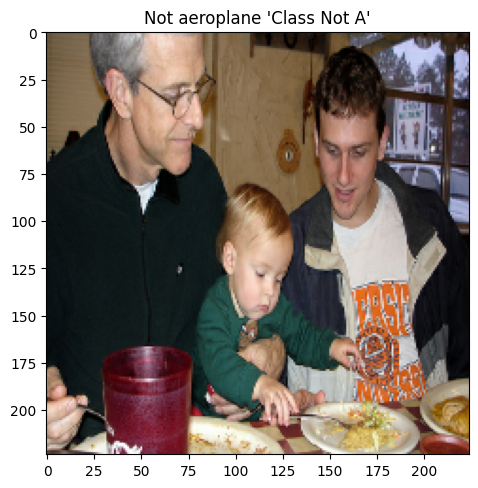

In [7]:
# Random check
def print_label(cat):
    return f"{category} 'Class A'" if cat == 1 else f"Not {category} 'Class Not A'"


def random_check(X, y):
    image_number = random.randint(0, len(X))
    img = X[image_number]
    cat = y[image_number]
    plt.figure(figsize=(12, 12))
    plt.subplot(121)
    plt.title(print_label(cat))
    plt.imshow(img)
    plt.show()


random_check(X, y)



In [8]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
print(X_train.shape)
print(y_train.shape)

(562, 224, 224, 3)
(562, 1)


In [9]:
# Model intialization
final_model = keras.models.Sequential()
final_model.add(model_vgg16)
# Add a flatten layer
final_model.add(Flatten())
final_model.add(Dense(1, activation="sigmoid"))

# Compile the model with categorical crossentropy loss and adam optimizer
final_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [14]:
# Model Fit
model_fit = final_model.fit(
    X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val)
)

Epoch 1/10
36/36 [==============================] - 5s 103ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.1734 - val_accuracy: 0.9291
Epoch 2/10
36/36 [==============================] - 4s 99ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1894 - val_accuracy: 0.9220
Epoch 3/10
36/36 [==============================] - 3s 97ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.1922 - val_accuracy: 0.9220
Epoch 4/10
36/36 [==============================] - 3s 95ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1958 - val_accuracy: 0.9220
Epoch 5/10
36/36 [==============================] - 3s 95ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2093 - val_accuracy: 0.9220
Epoch 6/10
36/36 [==============================] - 3s 94ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1974 - val_accuracy: 0.9220
Epoch 7/10
36/36 [==============================] - 3s 93ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.1993 - val_accuracy: 0.9220
Epoch 8/10
3

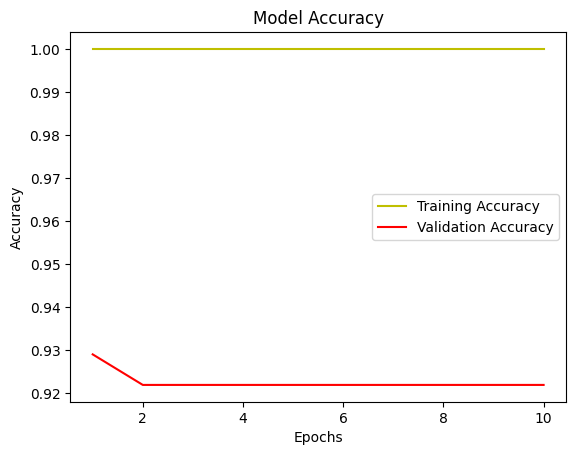

In [15]:
# plotting train and val accuracy in each epoch
accuracy = model_fit.history["accuracy"]
val_accuracy = model_fit.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "y", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
# Reading testing data
X_test, y_test = data_preprocessing(test_label_df)

1/1 [==============================] - 0s 489ms/step


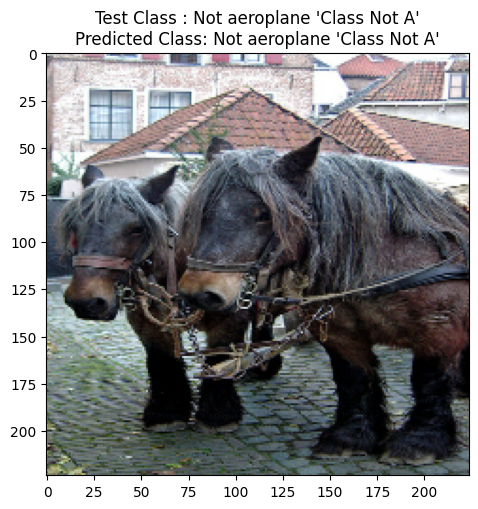

In [17]:
# Testing random unseen images
image_number = random.randint(0, len(X_test))
test_one = final_model.predict(np.array([X_test[image_number]]))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(
    f"Test Class : {print_label(y_test[image_number])}\n"
    + f"Predicted Class: {print_label(np.round_(test_one[0]))}"
)
plt.imshow(X_test[image_number])
plt.show()

In [18]:
# Checking Test Matrices
predicted_y = final_model.predict(X_test)
# Convert float values to binary
predicted_y = (np.round_(predicted_y)).reshape(-1)

# Calculate and print accuracy
accuracy = metrics.accuracy_score(y_test, predicted_y)
print(f"Accuracy: {accuracy}")

# Calculate and print precision
precision = metrics.precision_score(y_test, predicted_y)
print(f"Precision: {precision}")

# Calculate and print recall
recall = metrics.recall_score(y_test, predicted_y)
print(f"Recall: {recall}")

# Calculate and print f1-score
f1 = metrics.f1_score(y_test, predicted_y)
print(f"F1-score: {f1}")

182/182 [==============================] - 19s 104ms/step
Accuracy: 0.9546625450798557
Precision: 0.5864332603938731
Recall: 0.7813411078717201
F1-score: 0.67


In [19]:
# Knn Test
X_flattened = X.reshape(X.shape[0], -1)
X_validation_flattened = X_test.reshape(X_test.shape[0], -1)

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(X_flattened)
normalized_val_features = scaler.transform(X_validation_flattened)


# Train and predict kNN classifiers with different hyperparameters


k_values = [5, 7]
distance_metrics = ["euclidean", "manhattan"]

for k, distance_metric in itertools.product(k_values, distance_metrics):
    # Initialize kNN classifier
    knn_classifier = KNeighborsClassifier(
        n_neighbors=k, metric=distance_metric
    )

    # Train kNN classifier
    knn_classifier.fit(normalized_features, y)

    y_pred = knn_classifier.predict(normalized_val_features)

    accuracy_score_value = metrics.accuracy_score(y_test, y_pred)
    confusion_mat = metrics.confusion_matrix(y_test, y_pred)
    print(f"K Value -> {k}, Distance Metric -> {distance_metric}")
    print("Accuracy:", accuracy_score_value)
    print("Confusion Matrix:\n", confusion_mat)


K Value -> 5, Distance Metric -> euclidean
Accuracy: 0.5761634896101666
Confusion Matrix:
 [[3065 2415]
 [  53  290]]
K Value -> 5, Distance Metric -> manhattan
Accuracy: 0.6419371458011335
Confusion Matrix:
 [[3470 2010]
 [  75  268]]
K Value -> 7, Distance Metric -> euclidean
Accuracy: 0.6015799416108535
Confusion Matrix:
 [[3210 2270]
 [  50  293]]


KeyboardInterrupt: 